# Исследование посетителей супермаркета

## Цель
Провести комплексный многоаспектный анализ данных о посетителях супермаркета с целью выявления скрытых закономерностей в демографических характеристиках, уровне дохода и покупательском поведении. Исследование включает сегментацию клиентов, изучение взаимосвязей между ключевыми переменными (возраст, доход, затраты) и разработку прогностических моделей для поддержки решений в маркетинге и развития клиентской базы.

## Вопросы
1. На какие сегменты можно разделить клиентов супермаркета?
2. Какие зависимости существуют между возрастом, уровнем дохода и тратами клиентов?
3. Как влияет пол на распределение доходов и покупательских оценок?
4. Можно ли создать надёжную прогностическую модель для оценки Spending Score на основе возраста, уровня дохода и пола? Какие факторы являются наиболее значимыми?
5. Какие аномалии и выбросы присутствуют в данных, и как они могут влиять на результаты анализа?

## Описание
Для проведения исследования был взят следующий набор данных:
https://www.kaggle.com/datasets/vjchoudhary7/customer-segmentation-tutorial-in-python

Есть супермаркет и с помощью членских карт мы получаем некоторые базовые данные о своих клиентах, такие как идентификатор клиента, возраст, пол, годовой доход и рейтинг расходов.
Рейтинг расходов — это показатель, который вы присваиваете клиенту на основе заданных вами параметров, таких как поведение клиента и данные о покупках.

## План
1. Обзор данных
2. Визуализация данных
3. Вопрос 1. На какие сегменты можно разделить клиентов супермаркета?
4. Вопрос 2. Какие зависимости существуют между возрастом, уровнем дохода и тратами клиентов?
5. Вопрос 3. Как влияет пол на распределение доходов и покупательских оценок?

# Обзор данных
Проведём обзор данных с целью понять их структуру и проверить наличие ошибок

### Импорт библиотек

Определим также функцию для диагностики данных в dataframe

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

df = pd.read_csv('data\mall_customers.csv', sep = ',')

# функция для диагностики df
def df_diagnostics(df):
    # Собираем основные характеристики столбцов
    diag = pd.DataFrame({'dtypes': df.dtypes, 'count': df.count(), 'unique': df.nunique(),
                         'NaN count': df.isnull().sum(), 'NaN percentage': df.isnull().sum() / df.shape[0]})
    
    # Словарь описывающий, какую функцию применить для каждой метрики
    metrics = {'mean': lambda s: s.mean(), 'median': lambda s: s.median(), 'std': lambda s: s.std(),
               'min':  lambda s: s.min(),  'max':    lambda s: s.max()}
    
    # Используем цикл по словарю, чтобы вычислить метрики для каждого столбца
    for metric, func in metrics.items():
        diag[metric] = [func(df[col]) if pd.api.types.is_numeric_dtype(df[col]) else np.nan 
                        for col in df.columns]
    
    # Вычисляем количество дублирующих строк в DataFrame
    duplicates_count = df.duplicated().sum()
    print("Количество дублирующих строк:", duplicates_count)
    return diag.style.background_gradient(cmap='Set3', low=0.1, high=0.01)

### Обзор таблицы

In [136]:
df.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


### Диагностика данных

In [138]:
df_diagnostics(df)

Количество дублирующих строк: 0


,dtypes,count,unique,NaN count,NaN percentage,mean,median,std,min,max
CustomerID,int64,200,200,0,0.000000,100.500000,100.500000,57.879185,1.000000,200.000000
Gender,object,200,2,0,0.000000,nan,nan,nan,nan,nan
Age,int64,200,51,0,0.000000,38.850000,36.000000,13.969007,18.000000,70.000000
Annual Income (k$),int64,200,64,0,0.000000,60.560000,61.500000,26.264721,15.000000,137.000000
Spending Score (1-100),int64,200,84,0,0.000000,50.200000,50.000000,25.823522,1.000000,99.000000


Диагностика данных в таблице показала:
- дублирующих строк нет
- имена полей корректны
- типы данных соответствуют
- все клиенты по полю `CustomerID` уникальные
- пропусков нет
- данные о возрасте клиентов по полю `Age` в диапазоне от 18 до 70
- данные о годовом доходе по полю `Annual Income (k$)` в диапазоне от 15 до 137 k$
- данные о оценке расходов по полю `Spending Score (1-100)` в диапазоне от 1 до 99

# Визуализация данных

Выполним визуализацию данных для лучшего понимания их структуры.

Выводим диаграммы распределения значений для полей `Age`, `Annual Income (k$)` и `Spending Score (1-100)`

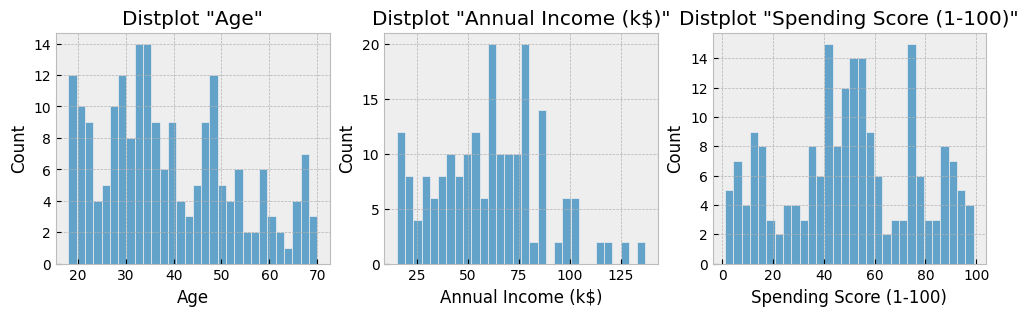

In [139]:
plt.style.use('bmh')
plt.figure(1, figsize=(12, 3))

n = 0
for x in ['Age', 'Annual Income (k$)', 'Spending Score (1-100)']:
    n += 1
    plt.subplot(1, 3, n)
    sns.histplot(df[x], bins=30)
    plt.title(f'Distplot "{x}"')

plt.show()

Выводим распределение значений в поле `Gender`

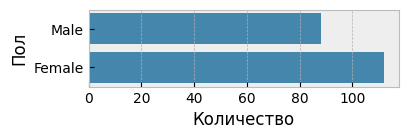

In [140]:
plt.figure(1 , figsize = (4 , 1))
sns.countplot(y = 'Gender' , data = df)
plt.xlabel('Количество'), plt.ylabel('Пол')
plt.show()

Построим графики зависимостей между возрастом, годовым доходом и показателем расходов

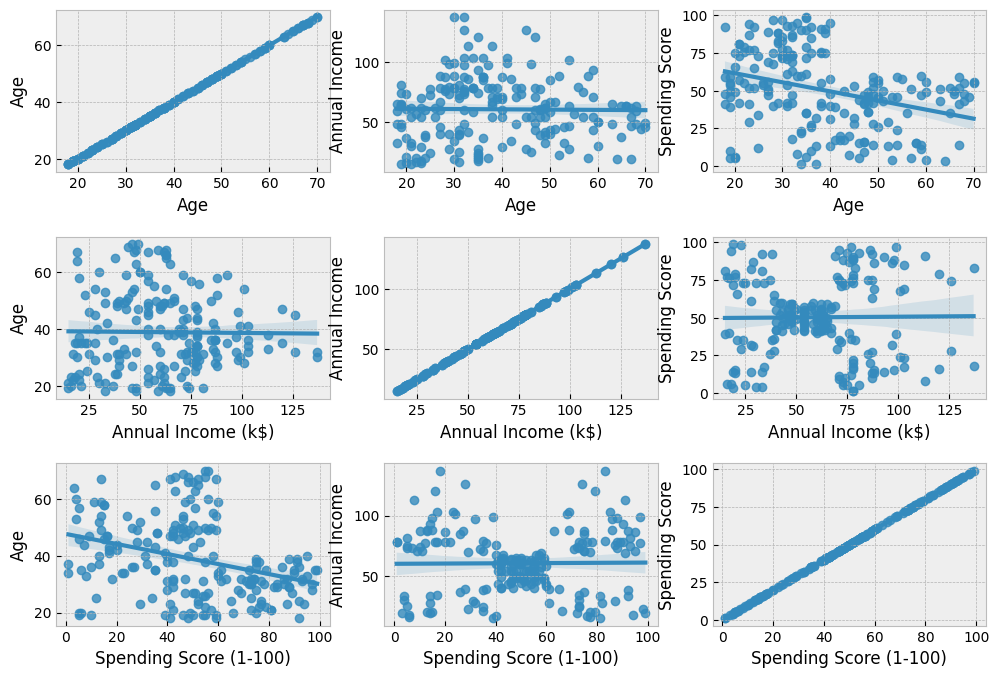

In [141]:
plt.figure(1 , figsize = (12 , 8))
n = 0 
for x in ['Age' , 'Annual Income (k$)' , 'Spending Score (1-100)']:
    for y in ['Age' , 'Annual Income (k$)' , 'Spending Score (1-100)']:
        n += 1
        plt.subplot(3 , 3 , n)
        plt.subplots_adjust(hspace = 0.4 , wspace = 0.2)
        sns.regplot(x = x , y = y , data = df)
        plt.ylabel(y.split()[0]+' '+y.split()[1] if len(y.split()) > 1 else y )
        
plt.show()

Построим график распределения годового дохода в зависимости от возраста и пола

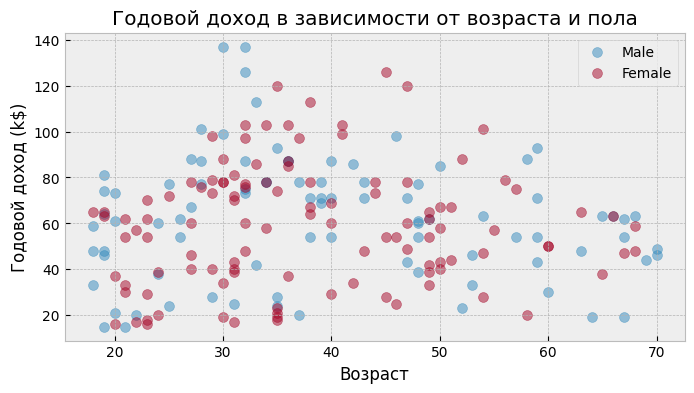

In [142]:
plt.figure(1 , figsize = (8 , 4))
for gender in ['Male' , 'Female']:
    plt.scatter(x = 'Age' , y = 'Annual Income (k$)' , data = df[df['Gender'] == gender] ,
                s = 50 , alpha = 0.5 , label = gender)
plt.xlabel('Возраст'), plt.ylabel('Годовой доход (k$)')
plt.title('Годовой доход в зависимости от возраста и пола')
plt.legend()
plt.show()

Построим график распределения показателя расходов в зависимости от возраста и пола

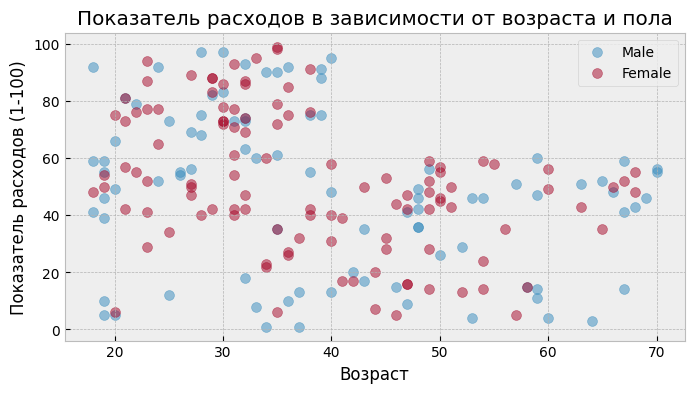

In [143]:
plt.figure(1 , figsize = (8 , 4))
for gender in ['Male' , 'Female']:
    plt.scatter(x = 'Age' , y = 'Spending Score (1-100)' , data = df[df['Gender'] == gender] ,
                s = 50 , alpha = 0.5 , label = gender)
plt.xlabel('Возраст'), plt.ylabel('Показатель расходов (1-100)')
plt.title('Показатель расходов в зависимости от возраста и пола')
plt.legend()
plt.show()

Построим график распределения показателя расходов в зависимости от годового дохода и пола

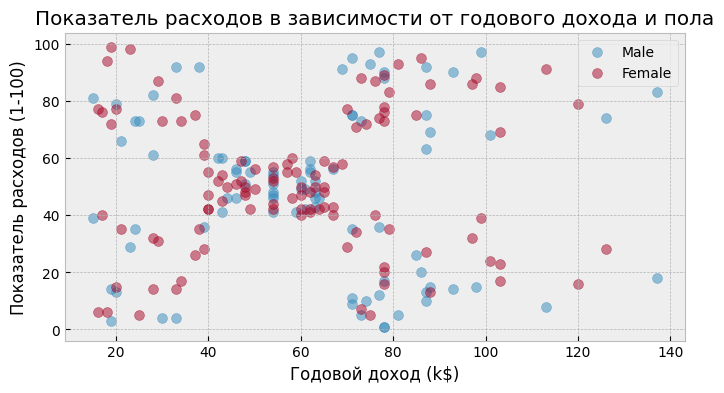

In [144]:
plt.figure(1 , figsize = (8 , 4))
for gender in ['Male' , 'Female']:
    plt.scatter(x = 'Annual Income (k$)',y = 'Spending Score (1-100)' ,
                data = df[df['Gender'] == gender] ,s = 50 , alpha = 0.5 , label = gender)
plt.xlabel('Годовой доход (k$)'), plt.ylabel('Показатель расходов (1-100)') 
plt.title('Показатель расходов в зависимости от годового дохода и пола')
plt.legend()
plt.show()

Построим скрипичные диаграммы с распределением значений по возрасту, годовому доходу и показателю расходов в зависимости от пола

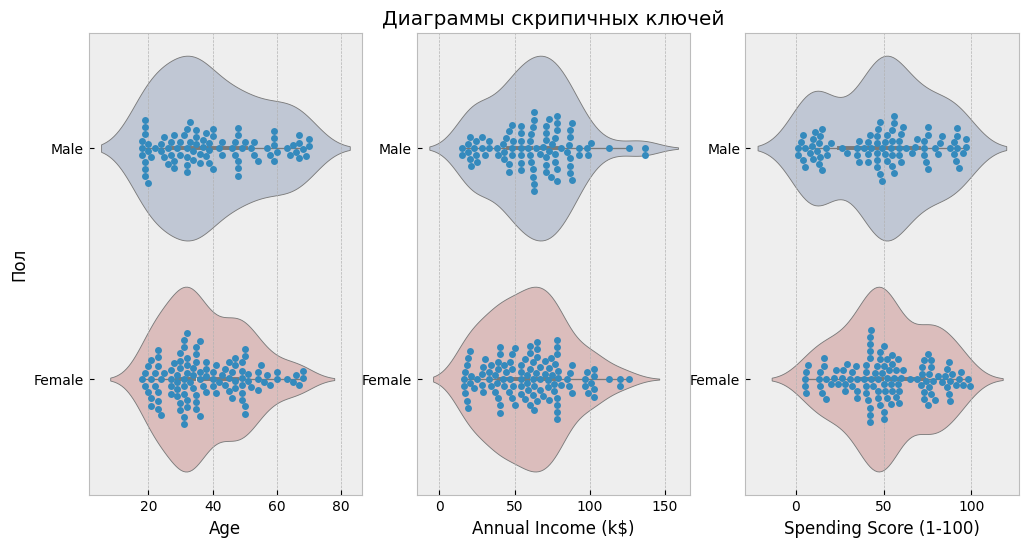

In [145]:
plt.figure(1, figsize=(12, 6))
n = 0
for cols in ['Age', 'Annual Income (k$)', 'Spending Score (1-100)']:
    n += 1
    plt.subplot(1, 3, n)
    plt.subplots_adjust(hspace=0.4, wspace=0.2)

    sns.violinplot(x=cols, y='Gender', data=df, hue='Gender', palette='vlag', legend=False)
    sns.swarmplot(x=cols, y='Gender', data=df)
    
    plt.ylabel('Пол' if n == 1 else '')
    plt.title('Диаграммы скрипичных ключей' if n == 2 else '')

plt.show()

# Вопрос 1. На какие сегменты можно разделить клиентов супермаркета?

Для сегментирования клиентов супермаркета выполним разделение клиентов на сегменты с помощью кластеризации методом `К-средних`

Внесём определения функций:
1. Для определения числа кластеров, на которые поделим клиентов
2. Для построения кластеров

In [237]:
def selecting_number_clusters(transf, n_clusters = range(2, 9), init = 'k-means++', n_init = 'auto',
                              tol = 0.0001, max_iter = 300, algorithm = 'lloyd', random_state = None):
    """
    Функция для определения числа кластеров.
    Большенство параметров ретранслируется в метод KMeans() для управления подбора параметров в цикле.
    """

    # если в модель переданы в ручную установленные центры центроид, то n_init = 1
    if init not in ['k-means++', 'random']:
        n_init = 1
    
    # Определение оптимального числа кластеров происходит путем поиска точки перегиба на графике инерции
    inertia = []

    for k in n_clusters:
        kmeans = KMeans(n_clusters = k, init = init, n_init = n_init, tol = tol, max_iter = max_iter,
                        algorithm = algorithm, random_state = random_state).fit(transf)
        inertia.append(kmeans.inertia_)

    # Выведем график
    plt.figure(figsize=(8, 4))
    plt.plot(n_clusters, inertia, marker='o')

    # Добавляем заголовок и подписываем оси
    plt.title(f'Зависимость инерции от кол-ва кластеров.')
    plt.xlabel('Число кластеров'), plt.ylabel('Инерция')
    plt.show()
    return None
    
def building_clusters(df, column_name, column_label, transf, scaler, n_clusters, init = 'k-means++',
                      n_init = 'auto', tol = 0.0001, max_iter = 300, algorithm = 'lloyd',
                      random_state = None, notes = None):
    """
    Функция для построения кластеров.
    :param df: df для построения графика.
    :param column_name: список с именами столбцов в df.
    :param column_label: список как назвать оси на графике.
    :param transf и scaler: для модели сегментации.
    :param notes: вывод параметров модели в заголовок графика. Для информирования во время перебора и подбора параметров.
    Остальные параметры переадресуются в метод KMeans() для управления подбора параметров в цикле.
    """

    # если в модель переданы в ручную установленные центры центроид, то n_init = 1
    if init not in ['k-means++', 'random']:
        n_init = 1

    x_column = column_name[0]
    y_column = column_name[1]
    x_labels = column_label[0]
    y_labels = column_label[1]
    
    # Создаём модель KMeans с кластерами
    kmeans = KMeans(n_clusters = n_clusters, init = init, n_init = n_init, tol = tol, max_iter = max_iter,
                    algorithm = algorithm, random_state = random_state).fit(transf)
    
    labels = kmeans.labels_
    centroids = kmeans.cluster_centers_

    # Переводим центроиды обратно в исходное пространство
    centroids_orig = scaler.inverse_transform(centroids)

    # Создаём сетку в исходном (оригинальном) пространстве
    h = 0.5  # шаг сетки
    x_min = df[x_column].min() - 1
    x_max = df[x_column].max() + 1
    y_min = df[y_column].min() - 1
    y_max = df[y_column].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    # Преобразуем сетку в стандартизированное пространство и делаем предсказание
    grid_points = np.c_[xx.ravel(), yy.ravel()]
    grid_points_scaled = scaler.transform(grid_points)
    Z = kmeans.predict(grid_points_scaled)
    Z = Z.reshape(xx.shape)

    # Строим график
    fig, ax = plt.subplots(figsize=(8, 4))
    ax.imshow(Z, interpolation='nearest', extent=(x_min, x_max, y_min, y_max),
              cmap=plt.cm.Pastel2, aspect='auto', origin='lower')

    # Отображаем исходные данные, центроиды и границы кластеров
    ax.scatter(df[x_column], df[y_column], c=labels, s=50)
    ax.scatter(centroids_orig[:, 0], centroids_orig[:, 1], s=150, c='red', alpha=0.5)
    
    if notes != None:
        title_text = f"Кластеров: {n_clusters}. {notes}"
    else:
        title_text = f"Разделение посетителей на {n_clusters} кластера"
    
    # Добавляем заголовок и подписываем оси
    ax.set_title(title_text)
    ax.set_xlabel(x_labels), ax.set_ylabel(y_labels)
    plt.show()
    return None

## Сегментация с использованием оценки возраста и расходов

Выполним подготовку данных и выведем график зависимости инерции от количества кластеров

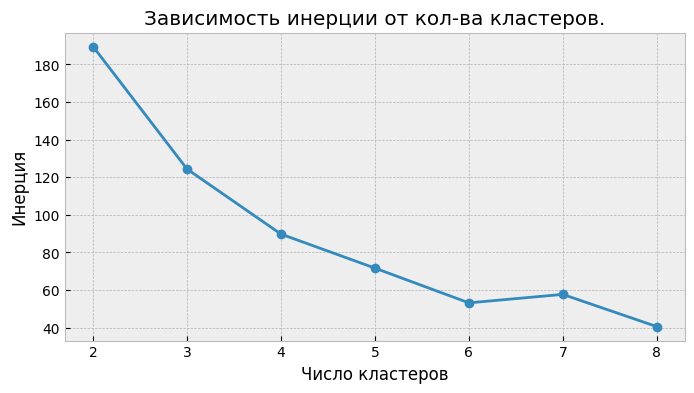

In [238]:
spend_features = df[['Age', 'Spending Score (1-100)']].values
spend_scaler = StandardScaler()
spend_transf = spend_scaler.fit_transform(spend_features)

selecting_number_clusters(transf = spend_transf)

Разделение посетителей оптимально на 3, 4 и 5 сегментов

Далее подбором параметров были определены следующие варианты сегментации

Разделение посетителей на 3 сегмента:

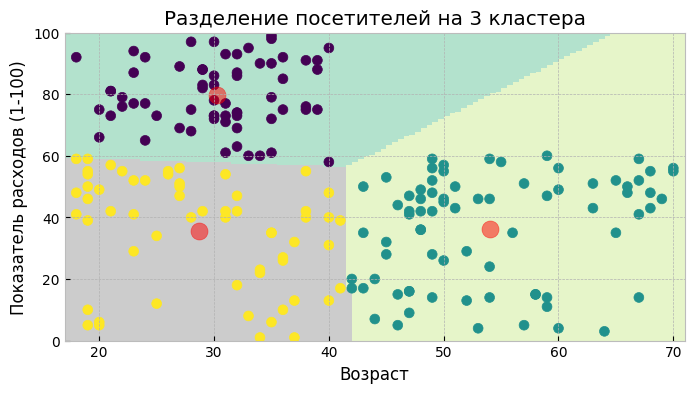

In [239]:
building_clusters(df = df, column_name = ['Age', 'Spending Score (1-100)'],
                  column_label = ['Возраст', 'Показатель расходов (1-100)'],
                  transf = spend_transf, scaler = spend_scaler, n_clusters = 3, random_state = 34)

Разделение посетителей на 4 сегмента:

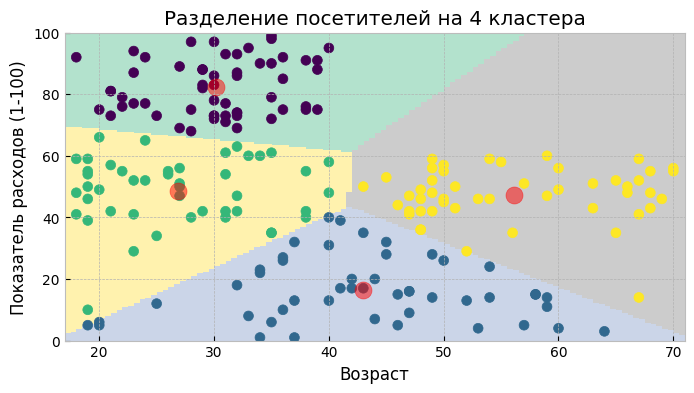

In [240]:
building_clusters(df = df, column_name = ['Age', 'Spending Score (1-100)'],
                  column_label = ['Возраст', 'Показатель расходов (1-100)'],
                  transf = spend_transf, scaler = spend_scaler, n_clusters = 4, tol=0.00001, random_state = 4)

Разделение посетителей на 5 сегментов:

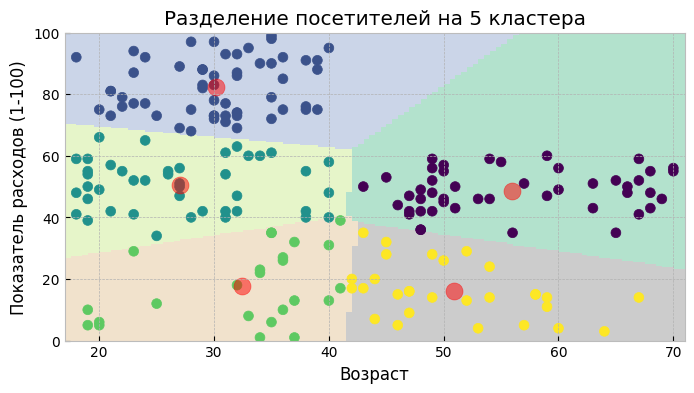

In [241]:
building_clusters(df = df, column_name = ['Age', 'Spending Score (1-100)'],
                  column_label = ['Возраст', 'Показатель расходов (1-100)'],
                  transf = spend_transf, scaler = spend_scaler, n_clusters = 5, tol=0.00001, random_state = 20)

## Сегментация с использованием оценки годового дохода и расходов

Выполним подготовку данных и выведем график зависимости инерции от количества кластеров

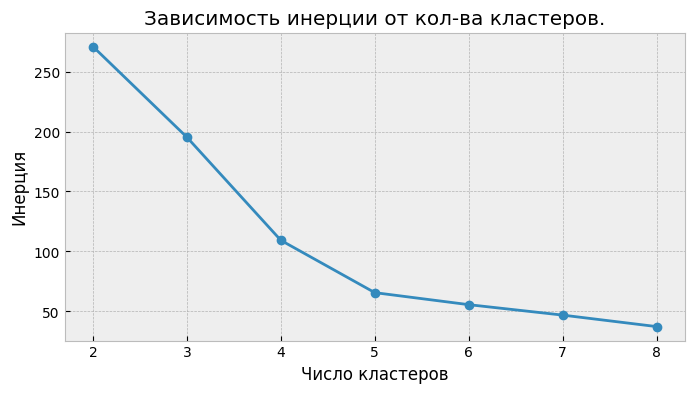

In [242]:
annual_features = df[['Annual Income (k$)', 'Spending Score (1-100)']].values
annual_scaler = StandardScaler()
annual_transf = annual_scaler.fit_transform(annual_features)

selecting_number_clusters(transf = annual_transf)

Разделение посетителей оптимально на 5 сегментов:

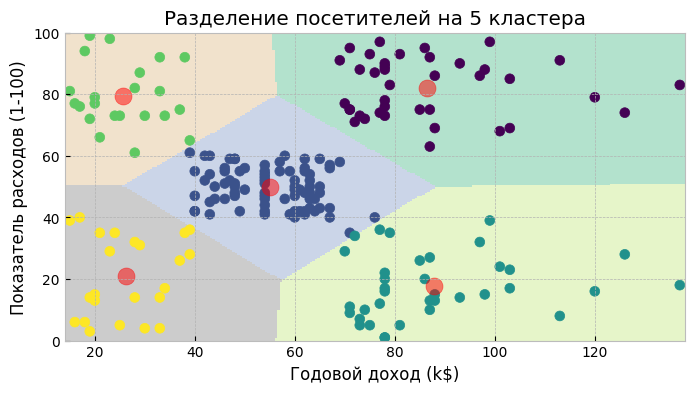

In [243]:
building_clusters(df = df, column_name = ['Annual Income (k$)', 'Spending Score (1-100)'],
                  column_label = ['Годовой доход (k$)', 'Показатель расходов (1-100)'],
                  transf = annual_transf, scaler = annual_scaler, n_clusters = 5)

# Вопрос 2. Какие зависимости существуют между возрастом, уровнем дохода и тратами клиентов?

## Расчёт корреляционной матрицы между возрастом, уровнем годового дохода и показателем расходов

In [244]:
corr_matrix = df[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']].corr()
print("Корреляционная матрица:\n", corr_matrix)

Корреляционная матрица:
                              Age  Annual Income (k$)  Spending Score (1-100)
Age                     1.000000           -0.012398               -0.327227
Annual Income (k$)     -0.012398            1.000000                0.009903
Spending Score (1-100) -0.327227            0.009903                1.000000


Расшифровка корреляционной матрицы:
- Возраст (Age) и Годовой Доход (Annual Income):
Коэффициент корреляции равен -0.012398. Это значит, что практически отсутствует какая-либо значимая связь между возрастом и годовым доходом. С увеличением возраста доходы снижаются не значительно.

- Возраст (Age) и Показатель Расходов (Spending Score):
Коэффициент корреляции составляет -0.327227, что свидетельствует о слабой отрицательной зависимости. Это означает, что с увеличением возраста расходы немного снижаются. То есть, чем старше человек, тем ниже его уровень трат.

- Годовой Доход (Annual Income) и Показатель Расходов (Spending Score):
Значение корреляции равно 0.009903, что также указывает на почти полное отсутствие связи. Получается, что увеличение доходов слабо связано с ростом уровня расходов. Люди с большим доходом не обязательно больше тратят.

Для наглядности построим тепловую карту на основании корреляционной матрицы

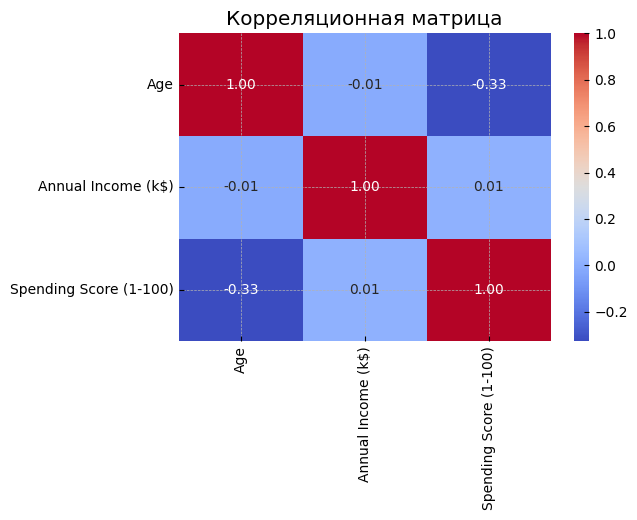

In [245]:
plt.figure(figsize=(6, 4))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Корреляционная матрица")
plt.show()

Для наглядности также построим графики распределения с линиями регрессии

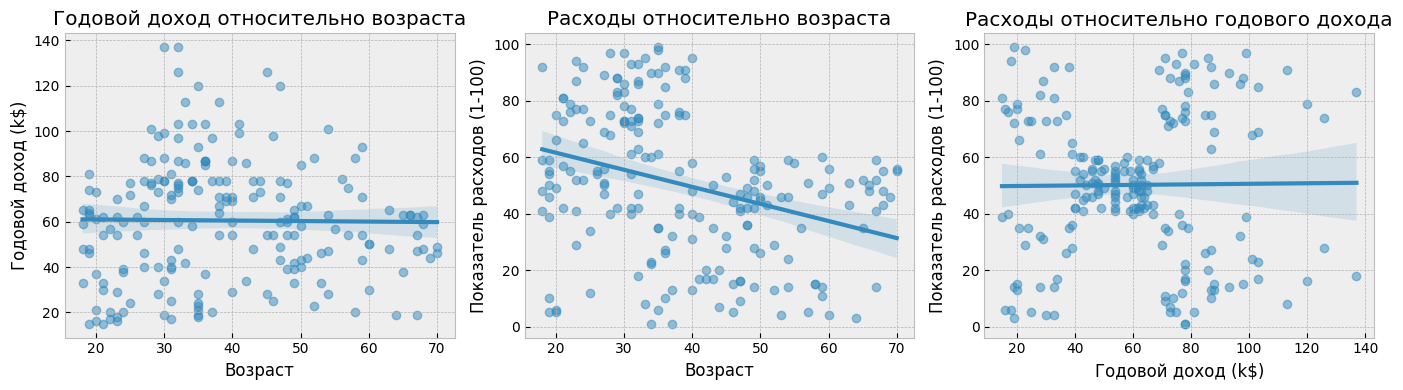

In [246]:
plt.figure(figsize=(14, 4))

plt.subplot(1, 3, 1)
sns.regplot(x='Age', y='Annual Income (k$)', data=df, scatter_kws={'alpha':0.5})
plt.title('Годовой доход относительно возраста')
plt.xlabel('Возраст'), plt.ylabel('Годовой доход (k$)')

plt.subplot(1, 3, 2)
sns.regplot(x='Age', y='Spending Score (1-100)', data=df, scatter_kws={'alpha':0.5})
plt.title('Расходы относительно возраста')
plt.xlabel('Возраст'), plt.ylabel('Показатель расходов (1-100)')

plt.subplot(1, 3, 3)
sns.regplot(x='Annual Income (k$)', y='Spending Score (1-100)', data=df, scatter_kws={'alpha':0.5})
plt.title('Расходы относительно годового дохода')
plt.xlabel('Годовой доход (k$)'), plt.ylabel('Показатель расходов (1-100)')

plt.tight_layout()

plt.show()

# Вопрос 3. Как влияет пол на распределение доходов и покупательских оценок?

## Построим сводные таблицы по половому признаку

In [247]:
print("Средние значения `годового дохода` и `показателя расходов` по полу:")
print(df.groupby('Gender')[['Annual Income (k$)', 'Spending Score (1-100)']].mean())

Средние значения `годового дохода` и `показателя расходов` по полу:
        Annual Income (k$)  Spending Score (1-100)
Gender                                            
Female           59.250000               51.526786
Male             62.227273               48.511364


Разьяснение покахателей в таблице:
1. Годовой доход:
   - Женщины имеют средний годовой доход около 59,25 тысяч долларов.
   - Мужчины имеют немного больший средний доход — примерно 62,23 тысячи долларов.
   
   Это означает, что мужчины зарабатывают чуть больше, чем женщины, хотя разница невелика.

2. Уровень расходов (по шкале от 1 до 100):
   - Средний уровень расходов среди женщин составляет 51,53.
   - Среди мужчин этот показатель ниже — 48,51.

   Таким образом, женщины тратят немного больше денег, чем мужчины.

Возможная интерпретация:
- Несмотря на то, что мужчины в среднем зарабатывают больше, женщины склонны тратить больше относительно своего дохода. Это может указывать на различия в покупательских привычках или предпочтениях между полами.

Далее представлена детальная статистика распределения годового дохода и показателя расходов по половому признаку

In [248]:
print("Детальная статистика:")
print(df.groupby('Gender')[['Annual Income (k$)', 'Spending Score (1-100)']].describe())

Детальная статистика:
       Annual Income (k$)                                                  \
                    count       mean        std   min    25%   50%    75%   
Gender                                                                      
Female              112.0  59.250000  26.011952  16.0  39.75  60.0  77.25   
Male                 88.0  62.227273  26.638373  15.0  45.50  62.5  78.00   

              Spending Score (1-100)                                        \
          max                  count       mean       std  min   25%   50%   
Gender                                                                       
Female  126.0                  112.0  51.526786  24.11495  5.0  35.0  50.0   
Male    137.0                   88.0  48.511364  27.89677  1.0  24.5  50.0   

                    
         75%   max  
Gender              
Female  73.0  99.0  
Male    70.0  97.0  


## Построим box plot с распределением годового дохода и показателя расходов по полу

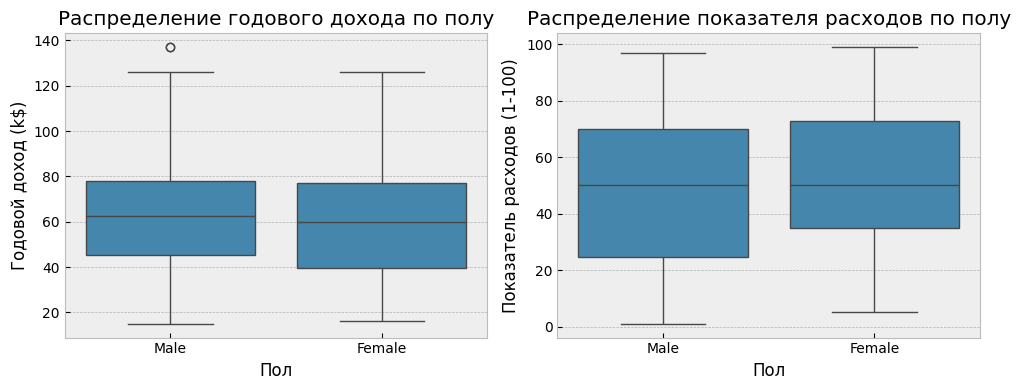

In [249]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
sns.boxplot(x='Gender', y='Annual Income (k$)', data=df)
plt.title('Распределение годового дохода по полу')
plt.xlabel('Пол'), plt.ylabel('Годовой доход (k$)')

plt.subplot(1, 2, 2)
sns.boxplot(x='Gender', y='Spending Score (1-100)', data=df)
plt.title('Распределение показателя расходов по полу')
plt.xlabel('Пол'), plt.ylabel('Показатель расходов (1-100)')

plt.tight_layout()
plt.show()

## Построим скрипичную диаграмму с распределением годового дохода и показателя расходов по полу

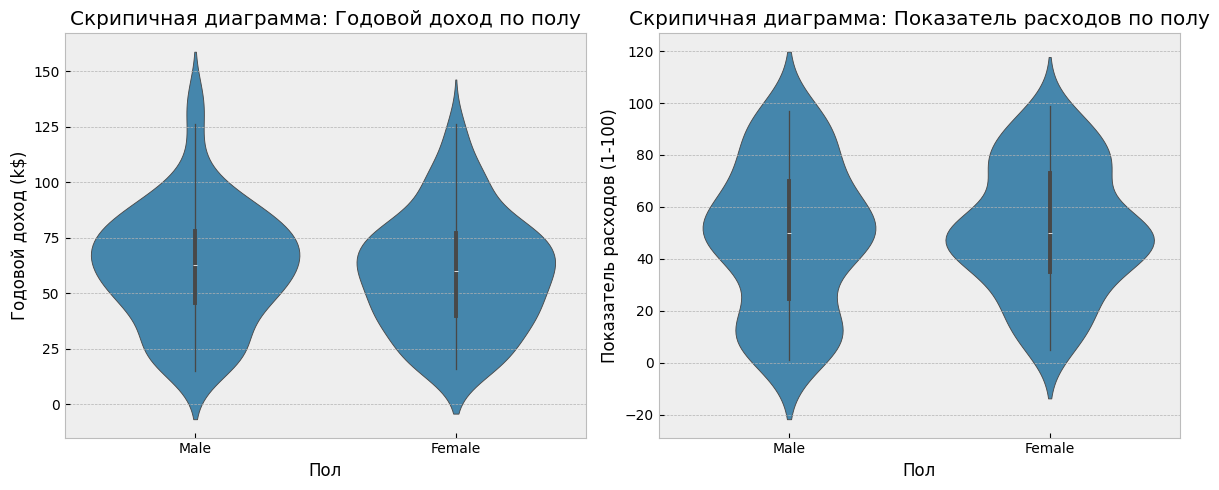

In [250]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.violinplot(x='Gender', y='Annual Income (k$)', data=df)
plt.title('Скрипичная диаграмма: Годовой доход по полу')
plt.xlabel('Пол'), plt.ylabel('Годовой доход (k$)')

plt.subplot(1, 2, 2)
sns.violinplot(x='Gender', y='Spending Score (1-100)', data=df)
plt.title('Скрипичная диаграмма: Показатель расходов по полу')
plt.xlabel('Пол'), plt.ylabel('Показатель расходов (1-100)')

plt.tight_layout()
plt.show()

## Построим интерактивную гистограмму с распределением годового дохода и показателя расходов по полу

In [251]:
import plotly.express as px

fig = px.histogram(df, x="Annual Income (k$)", color="Gender", barmode='overlay',
                   opacity=0.75, title="Распределение годового дохода по полу")
fig.show()

fig = px.histogram(df, x="Spending Score (1-100)", color="Gender", barmode='overlay',
                   opacity=0.75, title="Распределение показателя расходов по полу")
fig.show()